In [1]:
from pathlib import Path
from acm.estimators.galaxy_clustering import MinkowskiFunctionals
from acm.utils import setup_logging
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

setup_logging()

In [4]:
# read some random galaxy catalog
data_dir = '/pscratch/sd/e/epaillas/emc/hods/z0.5/yuan23_prior2/c000_ph000/'
data_fn = Path(data_dir) / 'hod3177.npy'
data = np.load(data_fn, allow_pickle=True).item()
boxsize = 2000.0
x = data['x']
y = data['y']
z_rsd = data['z_rsd']
data_positions = np.c_[x, y, z_rsd]

mf = MinkowskiFunctionals(boxsize=boxsize, boxcenter=boxsize/2, cellsize=5.0)
mf.assign_data(positions=data_positions)
mf.set_density_contrast(smoothing_radius=10)
_ = mf.run(thres_high=4)

[000091.81]  04-29 09:29  MinkowskiFunctionals         INFO     Initializing MinkowskiFunctionals.
[000091.81]  04-29 09:29  MinkowskiFunctionals         INFO     Box size: [2000. 2000. 2000.]
[000091.81]  04-29 09:29  MinkowskiFunctionals         INFO     Box center: [1000. 1000. 1000.]
[000091.81]  04-29 09:29  MinkowskiFunctionals         INFO     Box nmesh: [400 400 400]
[000096.35]  04-29 09:29  MinkowskiFunctionals         INFO     Set density contrast in 3.03 seconds.
[000096.35]  04-29 09:29  MinkowskiFunctionals         INFO     Generating lattice query points within the box.

Computing Minkowski functionals of the field...
Time taken = 31.68 seconds
[000137.50]  04-29 09:30  MinkowskiFunctionals         INFO     Minkowski functionals elapsed in 41.15 seconds.


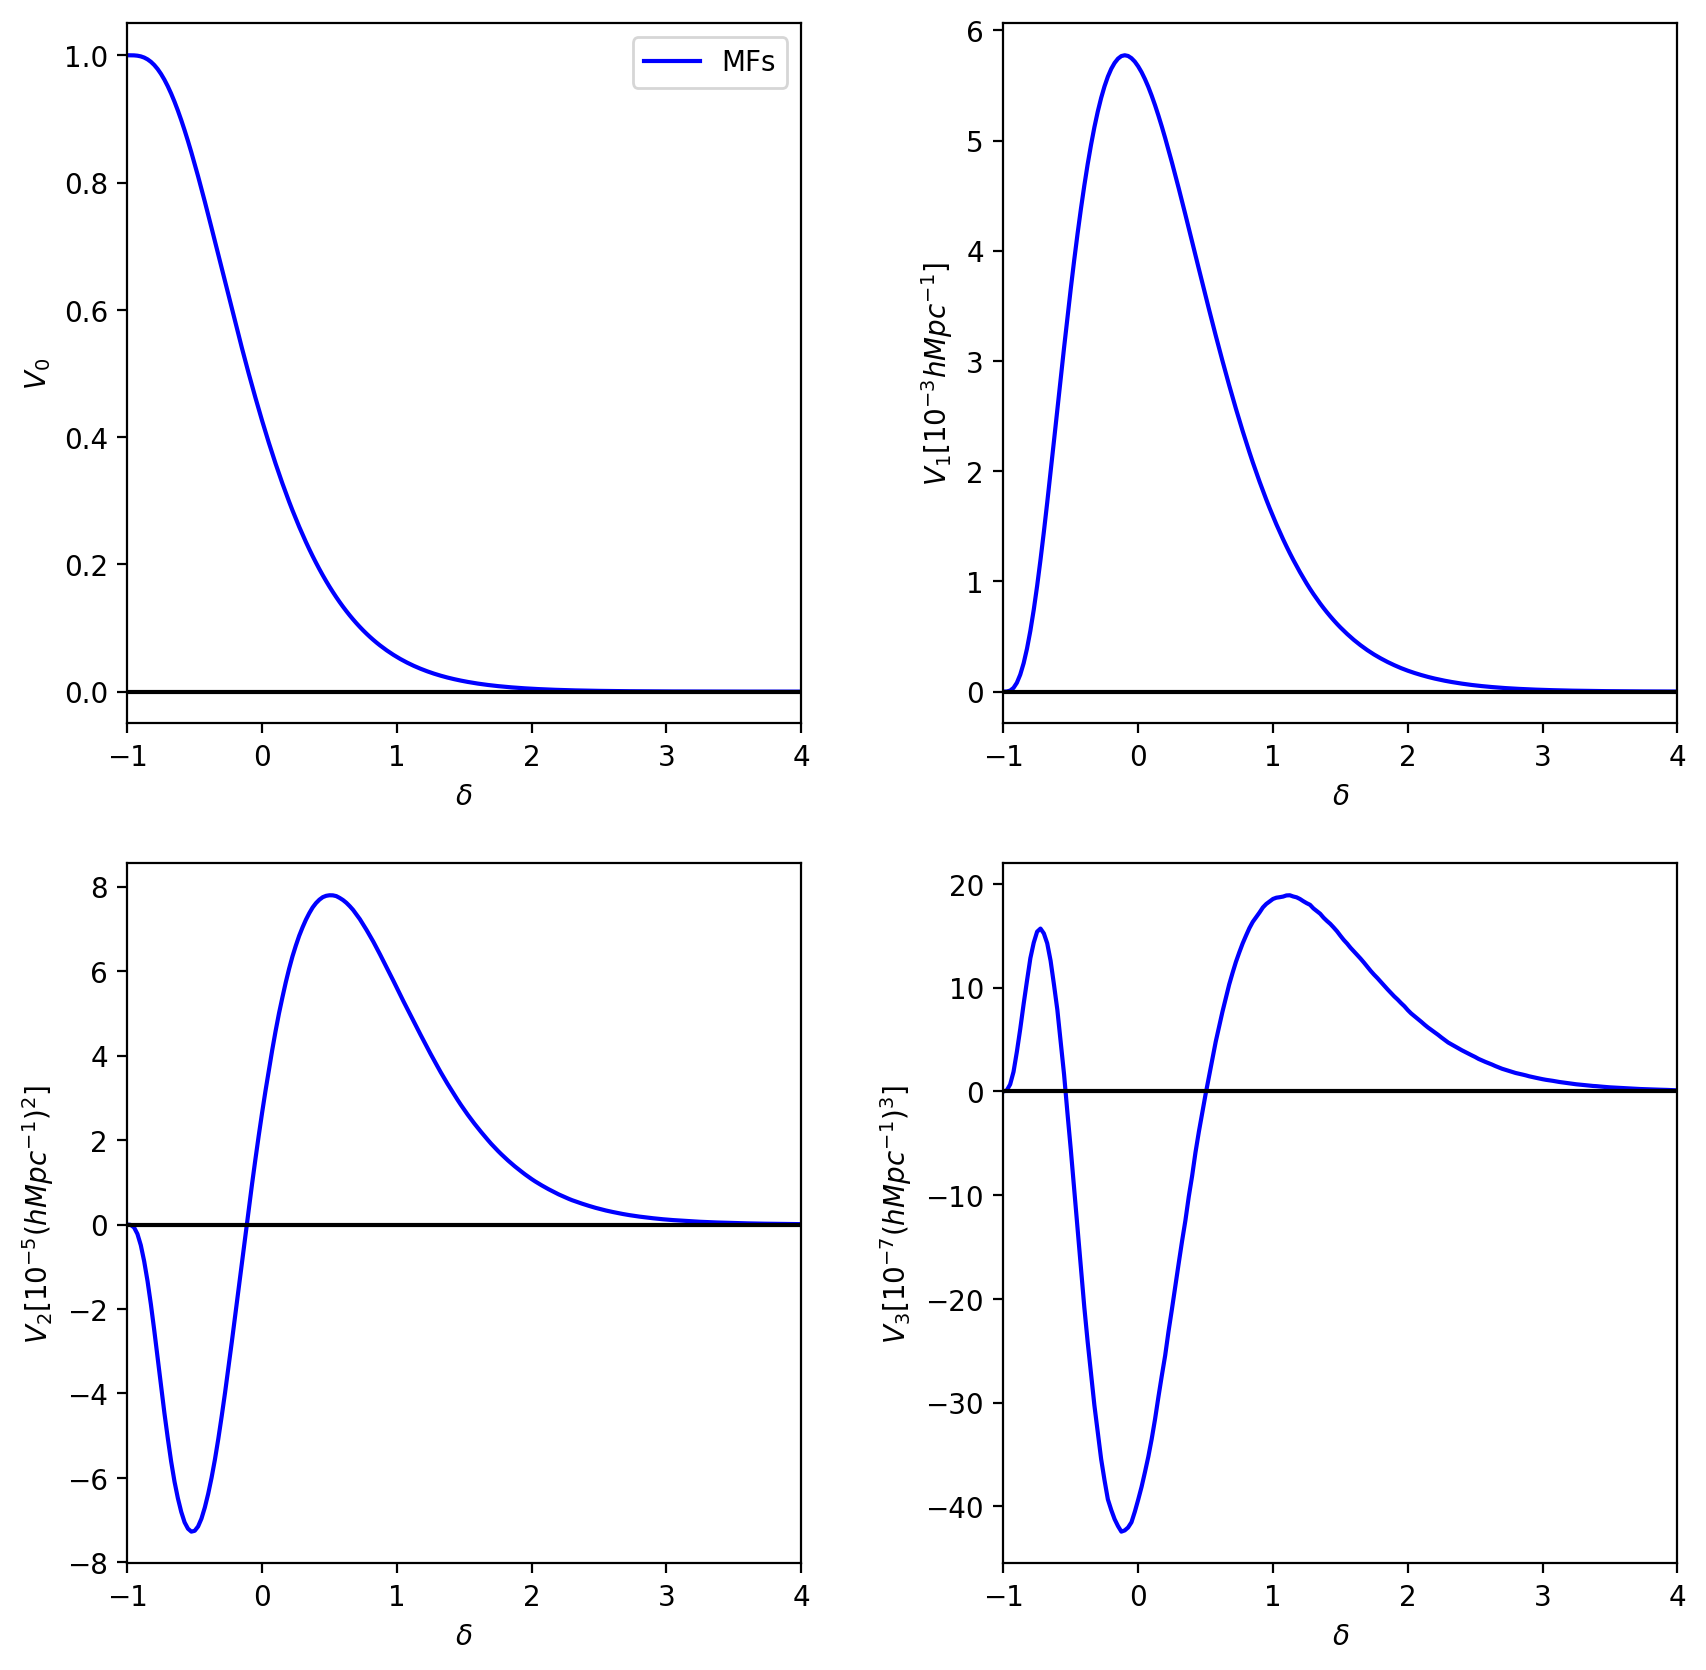

In [5]:
_ = mf.plot_MFs()

### Working with survey data

In [6]:
import fitsio
from cosmoprimo.fiducial import DESI
from pyrecon.utils import sky_to_cartesian


# def read_desi(filename, distance, zmin=0.45, zmax=0.6, RAmin=130, RAmax=170, DECmin=-10, DECmax=10):
def read_desi(filename, distance, zmin=0.45, zmax=0.6):
    """Read CMASS LSS catalogues."""
    data = fitsio.read(filename)
    mask = (data['Z'] > zmin) & (data['Z'] < zmax)
    # mask = (data['Z'] > zmin) & (data['Z'] < zmax) & (data['RA'] < RAmax) & (data['RA'] > RAmin) & (data['DEC'] < DECmax) & (data['DEC'] > DECmin)
    ra = data[mask]['RA']
    dec = data[mask]['DEC']
    redshift = data[mask]['Z']
    weights = data[mask]['WEIGHT']
    dist = distance(redshift)
    positions = sky_to_cartesian(dist=dist, ra=ra, dec=dec)
    return positions, weights

setup_logging()
cosmo = DESI()
distance = cosmo.comoving_radial_distance

version = 'v1.2/blinded'
tracer = 'LRG'
zmin, zmax = 0.4, 0.6
region = 'NGC'
nrandoms = 5

# read data
data_dir = f'/global/cfs/cdirs/desi/survey/catalogs/Y1/LSS/iron/LSScats/{version}'
data_fn = Path(data_dir) / f'{tracer}_{region}_clustering.dat.fits'
data_positions, data_weights = read_desi(distance=distance, filename=data_fn, zmin=zmin, zmax=zmax)

# read randoms
randoms_positions = []
randoms_weights = []
for i in range(nrandoms):
    randoms_dir = Path('/global/cfs/cdirs/desi/survey/catalogs/Y1/LSS/iron/LSScats/v1.1/blinded/')
    randoms_fn = randoms_dir / f'{tracer}_{region}_{i}_clustering.ran.fits'
    randoms_positions_i, randoms_weights_i = read_desi(distance=distance, filename=randoms_fn,
                                                       zmin=zmin, zmax=zmax)
    randoms_positions.append(randoms_positions_i)
    randoms_weights.append(randoms_weights_i)
randoms_positions = np.concatenate(randoms_positions)
randoms_weights = np.concatenate(randoms_weights)

In [7]:
mf = MinkowskiFunctionals(positions=randoms_positions, cellsize=5.0)
mf.assign_data(positions=data_positions, weights=data_weights)
mf.assign_randoms(positions=randoms_positions, weights=randoms_weights)
mf.set_density_contrast(smoothing_radius=10)

[000054.55]  04-29 10:16  MinkowskiFunctionals         INFO     Initializing MinkowskiFunctionals.
[000054.60]  04-29 10:16  MinkowskiFunctionals         INFO     Box size: [2740. 4235. 2660.]
[000054.60]  04-29 10:16  MinkowskiFunctionals         INFO     Box center: [-621.63848299  -84.969653    618.97756543]
[000054.61]  04-29 10:16  MinkowskiFunctionals         INFO     Box nmesh: [548 847 532]
[000099.55]  04-29 10:17  MinkowskiFunctionals         INFO     Set density contrast in 41.69 seconds.


RealMesh(dtype=float64, nmesh=[548 847 532], boxsize=[2740. 4235. 2660.], boxcenter=[-621.63848299  -84.969653    618.97756543])

[000099.57]  04-29 10:17  MinkowskiFunctionals         INFO     Generating lattice query points within the box.

Computing Minkowski functionals of the field...
Time taken = 14.13 seconds
[000147.67]  04-29 10:18  MinkowskiFunctionals         INFO     Minkowski functionals elapsed in 48.10 seconds.


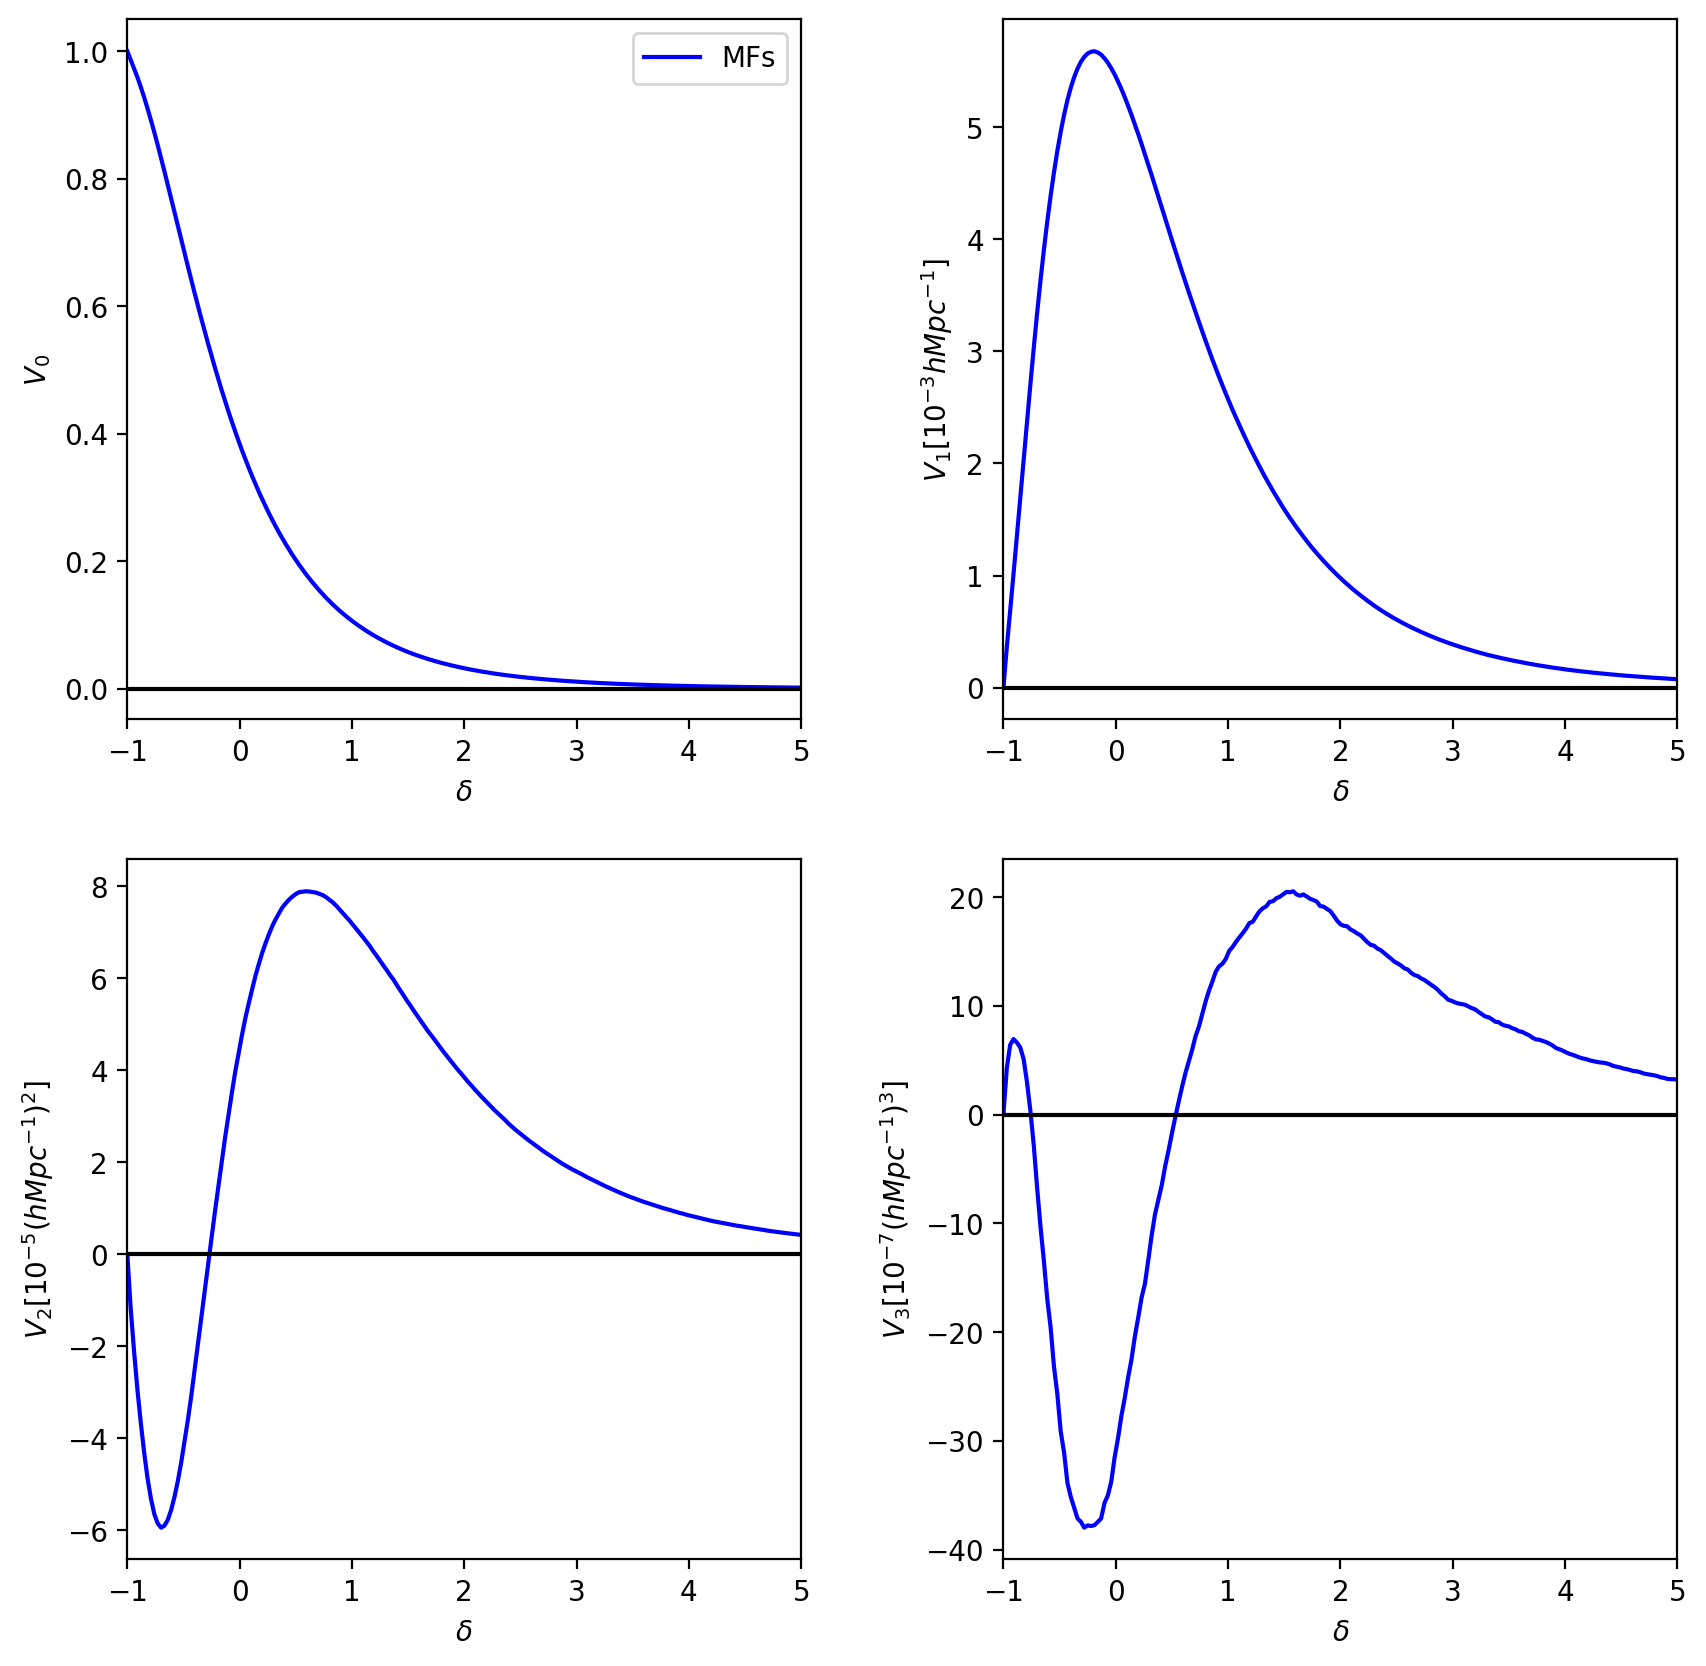

In [8]:
_ = mf.run(thres_high=5)
_ = mf.plot_MFs()

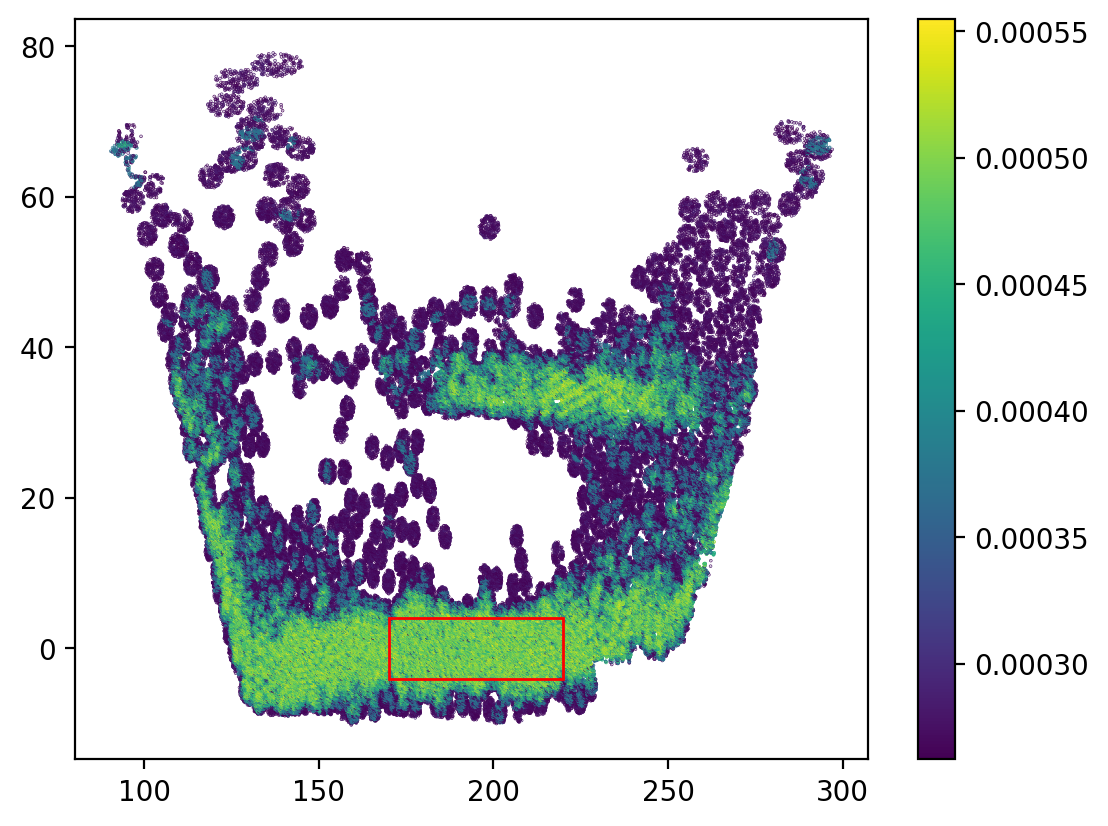

In [12]:
data_dir = f'/global/cfs/cdirs/desi/survey/catalogs/Y1/LSS/iron/LSScats/{version}'
data_fn = Path(data_dir) / f'{tracer}_{region}_clustering.dat.fits'

zmin, zmax = 0.4, 0.6
data = fitsio.read(data_fn)
mask = (data['Z'] > zmin) & (data['Z'] < zmax)
# mask = (data['Z'] > zmin) & (data['Z'] < zmax) & (data['RA'] < RAmax) & (data['RA'] > RAmin) & (data['DEC'] < DECmax) & (data['DEC'] > DECmin)
ra = data[mask]['RA']
dec = data[mask]['DEC']
nz = data[mask]['NX']

fig, ax = plt.subplots()
pos = ax.scatter(ra,dec,s=0.05,c=nz)
ax.add_patch(plt.Rectangle((170, -4), 50, 8, color='red',fill=False))
fig.colorbar(pos,ax=ax)

Only measure the Minkowski functionals for galaxies within high density area

In [14]:
def read_desi(filename, distance, zmin=0.45, zmax=0.6, RAmin=170, RAmax=220, DECmin=-4, DECmax=4):
    """Read CMASS LSS catalogues."""
    data = fitsio.read(filename)
    mask = (data['Z'] > zmin) & (data['Z'] < zmax) & (data['RA'] < RAmax) & (data['RA'] > RAmin) & (data['DEC'] < DECmax) & (data['DEC'] > DECmin)
    ra = data[mask]['RA']
    dec = data[mask]['DEC']
    redshift = data[mask]['Z']
    weights = data[mask]['WEIGHT']
    dist = distance(redshift)
    positions = sky_to_cartesian(dist=dist, ra=ra, dec=dec)
    return positions, weights

setup_logging()
cosmo = DESI()
distance = cosmo.comoving_radial_distance

version = 'v1.2/blinded'
tracer = 'LRG'
zmin, zmax = 0.4, 0.6
region = 'NGC'
nrandoms = 5

# read data
data_dir = f'/global/cfs/cdirs/desi/survey/catalogs/Y1/LSS/iron/LSScats/{version}'
data_fn = Path(data_dir) / f'{tracer}_{region}_clustering.dat.fits'
data_positions, data_weights = read_desi(distance=distance, filename=data_fn, zmin=zmin, zmax=zmax)

# read randoms
randoms_positions = []
randoms_weights = []
for i in range(nrandoms):
    randoms_dir = Path('/global/cfs/cdirs/desi/survey/catalogs/Y1/LSS/iron/LSScats/v1.1/blinded/')
    randoms_fn = randoms_dir / f'{tracer}_{region}_{i}_clustering.ran.fits'
    randoms_positions_i, randoms_weights_i = read_desi(distance=distance, filename=randoms_fn,
                                                       zmin=zmin, zmax=zmax)
    randoms_positions.append(randoms_positions_i)
    randoms_weights.append(randoms_weights_i)
randoms_positions = np.concatenate(randoms_positions)
randoms_weights = np.concatenate(randoms_weights)

[000019.70]  04-29 10:28  MinkowskiFunctionals         INFO     Initializing MinkowskiFunctionals.
[000019.72]  04-29 10:28  MinkowskiFunctionals         INFO     Box size: [1065. 1880.  325.]
[000019.72]  04-29 10:28  MinkowskiFunctionals         INFO     Box center: [-1.18144715e+03 -3.59689612e+02 -5.24606635e-02]
[000019.72]  04-29 10:28  MinkowskiFunctionals         INFO     Box nmesh: [213 376  65]
[000021.58]  04-29 10:28  MinkowskiFunctionals         INFO     Set density contrast in 0.99 seconds.
[000021.58]  04-29 10:28  MinkowskiFunctionals         INFO     Generating lattice query points within the box.

Computing Minkowski functionals of the field...
Time taken = 0.69 seconds
[000023.16]  04-29 10:28  MinkowskiFunctionals         INFO     Minkowski functionals elapsed in 1.58 seconds.


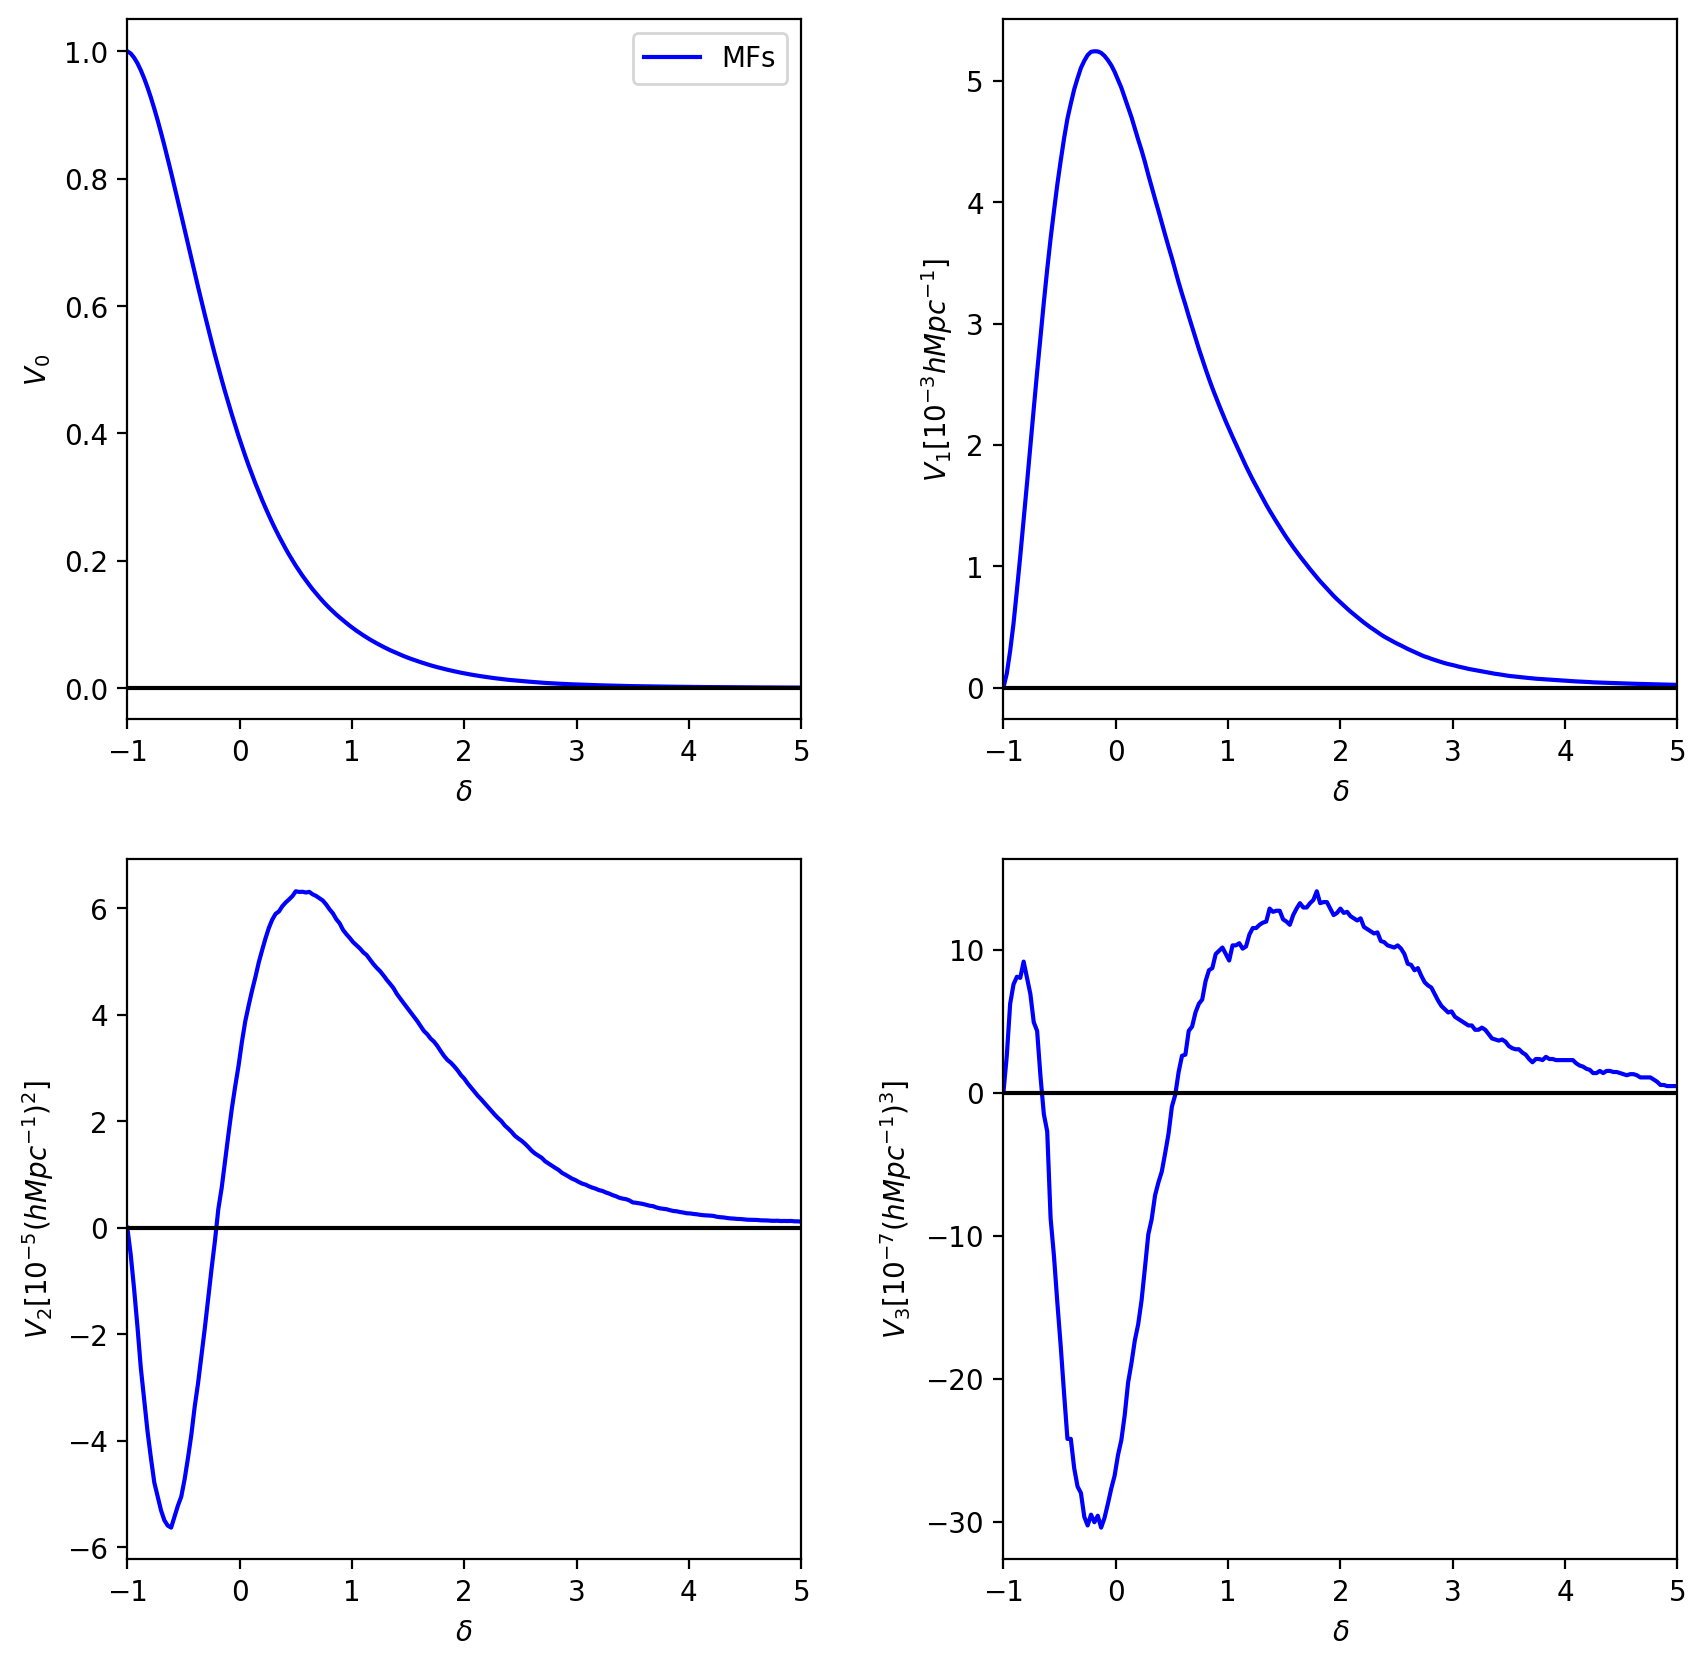

In [15]:
mf = MinkowskiFunctionals(positions=randoms_positions, cellsize=5.0)
mf.assign_data(positions=data_positions, weights=data_weights)
mf.assign_randoms(positions=randoms_positions, weights=randoms_weights)
mf.set_density_contrast(smoothing_radius=10)
_ = mf.run(thres_high=5)
_ = mf.plot_MFs()